In [125]:
import networkx as nx
import random
import tsplib95
import math

problem = tsplib95.load(r"C:\Users\user\Desktop\programming\B\B-n63-k10.vrp")

k = 10     # number of vehicles
n = problem.dimension      # number of demand points

depot = 0                       
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1,nx.DiGraph()) 

In [126]:
my_pos = problem.node_coords # pos[i] = (x_i, y_i)

# let's locate the depot in the middle
my_pos[depot] = (0.5, 0.5)

#nx.draw(G, pos=my_pos)

In [127]:
problem.capacity

100

In [128]:
# for convenience, suppose that distances are Euclidean

def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [129]:
# suppose each vehicle has capacity 100
Q = problem.capacity

# suppose each demand point has demand 20
q = problem.demands

In [130]:
import gurobipy as gp
from gurobipy import GRB

In [131]:
# First, solve a relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[i,j]['length']* x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Enter each demand point once
m.addConstrs( gp.quicksum( x[i,j] for i in G.predecessors(j) ) == 1 for j in dem_points )

# Leave each demand point once
m.addConstrs( gp.quicksum( x[i,j] for j in G.successors(i) ) == 1 for i in dem_points )

# Leave the depot k times
m.addConstr( gp.quicksum( x[depot,j] for j in G.successors(depot) ) == k )

m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 127 rows, 4032 columns and 8001 nonzeros
Model fingerprint: 0x88f0eb99
Variable types: 0 continuous, 4032 integer (4032 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 4220.6147063
Presolve time: 0.04s
Presolved: 127 rows, 4032 columns, 8001 nonzeros
Variable types: 0 continuous, 4032 integer (4032 binary)

Root relaxation: objective 6.330179e+02, 183 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     633.0178923  633.017

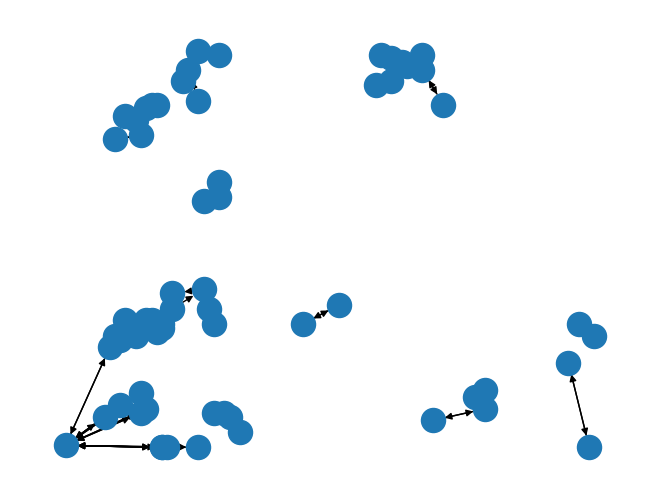

In [132]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

In [133]:
# Add the MTZ variables and constraints, and solve
u = m.addVars( G.nodes )

u[depot].LB = 0
u[depot].UB = 0

for i in dem_points:
    u[i].LB = q[i]
    u[i].UB = Q

c = m.addConstrs( u[i] - u[j] + Q * x[i,j] <= Q - q[j] for i,j in G.edges if j != depot )

m.Params.TimeLimit = 120
m.optimize()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 4096 rows, 4096 columns and 19908 nonzeros
Model fingerprint: 0xfeb4d861
Variable types: 64 continuous, 4032 integer (4032 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 63 rows and 1 columns
Presolve time: 0.06s
Presolved: 4033 rows, 4095 columns, 19719 nonzeros
Variable types: 63 continuous, 4032 integer (4032 binary)

Root relaxation: objective 6.475135e+02, 352 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

In [68]:
# Try again, using stronger ("lifted") version of these constraints

#m.remove(c)  # remove the previous MTZ constraints
#q[depot] = 0
#m.addConstrs( u[i] - u[j] + Q * x[i,j] + ( Q - q[i] - q[j] ) * x[j,i] <= Q - q[j] for i,j in G.edges if j != depot )

#m.reset()    # start solve process from scratch
#m.optimize()

In [69]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

AttributeError: Unable to retrieve attribute 'x'